In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from copy import deepcopy

%matplotlib inline

In [3]:
from networkx.drawing.nx_pydot import graphviz_layout
from shapely.geometry import Point

In [4]:
plt.rcParams['figure.figsize'] = 10,7
plt.rcParams['font.size'] = 15
plt.rcParams["pdf.fonttype"] = 42

In [5]:
# node position for all slices
nlist = pd.read_csv('../edgelists_yearlyslice/nodelist.csv',index_col=0)
nlist = pd.concat([nlist,pd.DataFrame([[0,47.498382,19.040471,None,None]],columns=nlist.columns)],ignore_index=True)

In [7]:
cities = gpd.GeoDataFrame(gpd.read_file('../iwiw_data/maps/OSN_region.shp'), crs = 'epsg:23700')
iwiw_codes = nlist.set_index('CityName')['CityId'].to_dict()
cities['iwiw_code'] = cities['HELYES']\
    .str.normalize('NFKD')\
    .str.encode('ascii', errors='ignore')\
    .str.decode('utf-8').map(iwiw_codes)

In [8]:
# projecting to EOV CRS (EPSG:23700)
nlist['geometry'] = nlist.apply(lambda r: Point(r['Longitude'],r['Latitude']),axis=1)
nlist['eov_x'] = gpd.GeoDataFrame(nlist,crs = 'epsg:4326').to_crs('epsg:23700').geometry.map(lambda p: p.coords[0][0])
nlist['eov_y'] = gpd.GeoDataFrame(nlist,crs = 'epsg:4326').to_crs('epsg:23700').geometry.map(lambda p: p.coords[0][1])
nlist['geometry_eov'] = gpd.GeoDataFrame(nlist,crs = 'epsg:4326').to_crs('epsg:23700')['geometry']

In [9]:
nlist.drop([c for c in nlist.columns if "geom" in c],axis=1).to_csv('nodes_all.csv',header=True,index=False)

In [10]:
valid = set(gpd.sjoin(cities,gpd.GeoDataFrame(nlist,geometry="geometry_eov"),op='contains')['CityId'])
nlist = nlist[nlist.CityId.isin(valid)]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:23700 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [12]:
lims = np.array([2003.0,2005.5,2009.5,2013.0])

In [13]:
# fixed node positions for slices
pos = nlist.set_index('CityId').apply(lambda row: [row['eov_x'],row['eov_y']],axis=1).to_dict()

elists = {1:[], 2:[], 3:[]}

# going through yearly edgelists and concatenating them
for f in os.listdir('../edgelists_yearlyslice/'):
    if 'edgelist' in f:
        # ev a fajlnevbol
        year = f.split('_')[1].split('-')[0]
        print(year, np.digitize(float(year),lims))
        elist  = pd.read_csv('../edgelists_yearlyslice/'+f,index_col=0)
        elist = elist[(elist["CityId"].isin(valid)&elist["InvitorCityId"].isin(valid))]
        elists[np.digitize(float(year),lims)].append(elist)

# merging edgelists
for k in elists:
    # sum outdegree
    elist = pd.concat(elists[k]).groupby(['CityId','InvitorCityId']).sum().reset_index()
    # excluding self-loops
    elist = elist[elist['CityId']!=elist['InvitorCityId']]
    elist['CityId'] = elist['CityId'].map(int)
    elist['InvitorCityId'] = elist['InvitorCityId'].map(int)
    # dumping outdegree to dict
    norm = elist.groupby('InvitorCityId').sum()['NumOutInvs'].to_dict()
    elist['norm'] = elist['InvitorCityId'].map(norm)
    # outgoing invitation probability
    elist['p'] = elist['NumOutInvs'] / elist['norm']
    # log transforming probability
    elist['weight'] = elist['p'].map(np.log)*(-1)
    elists[k]=elist

2009 2
2008 2
2005 1
2011 3
2003 1
2007 2
2006 2
2010 3
2012 3
2004 1


In [15]:
# labels
limname = {1:'2003-2005', 2:'2006-2009',3:'2010-2012'}

## Shortest paths to all settlements from Budapest (Dijkstra)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


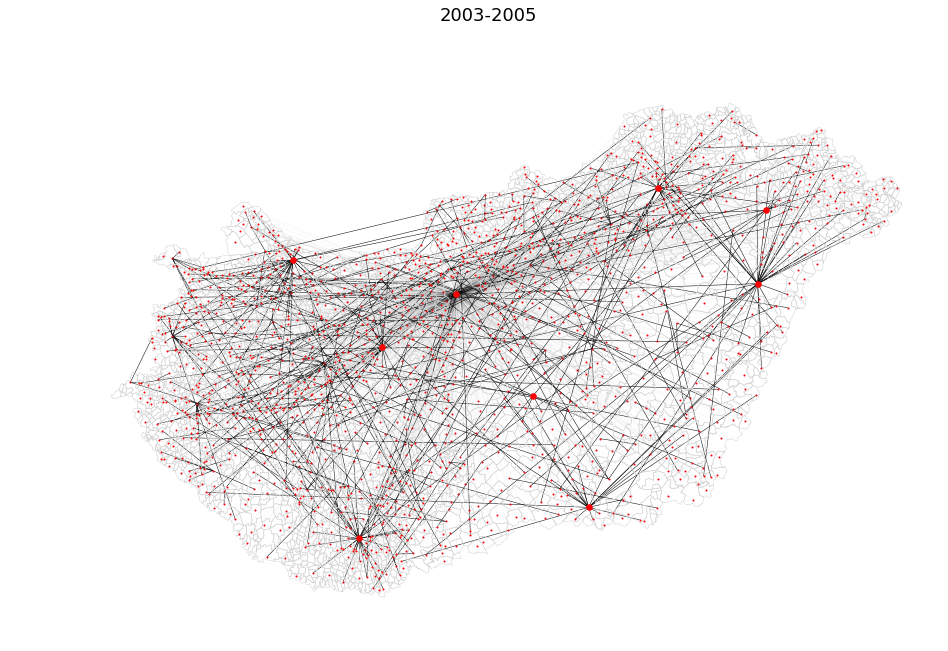

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


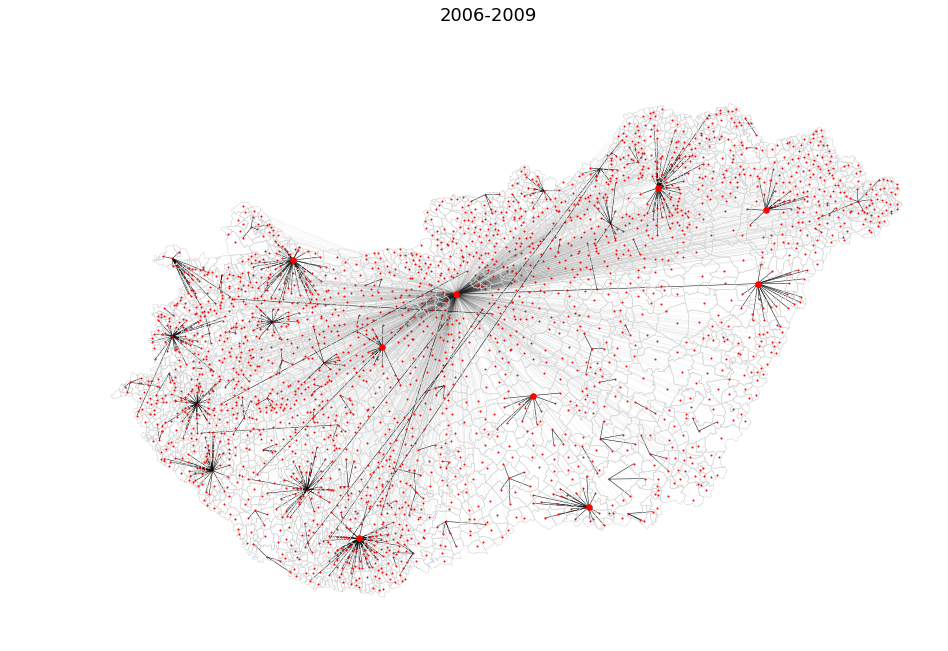

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


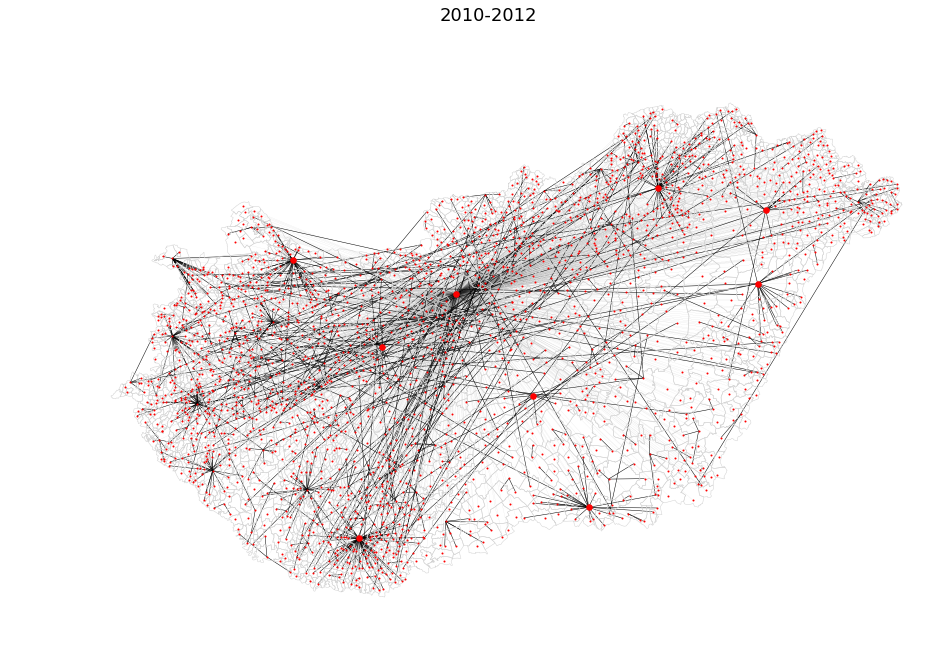

In [16]:
for k in elists:
    elist = elists[k]

    # loading the edgelist into a weighted graph
    G = nx.DiGraph()
    G.add_weighted_edges_from(elist[['InvitorCityId','CityId','weight']].values,weight='weight')

    # shortest paths from Budapest
    tree_l = nx.shortest_paths.weighted.single_source_dijkstra_path_length(G,source=379)

    # there might be multiple different shortest paths, finding these edges based on path weights
    elist['source_l'] = elist['InvitorCityId'].map(tree_l)
    elist['target_l'] = elist['CityId'].map(tree_l)
    elist['diff_l'] = elist['target_l'] - elist['source_l']
    tlist = elist[np.abs(elist['diff_l']-elist['weight'])<1e-5]
    tlist[['CityId','InvitorCityId','p','NumOutInvs']].to_csv('../iwiw_data/dijkstra_edges_'+str(k)+'.csv',header=True,index=False)
    

    T = nx.Graph()
    T.add_edges_from(tlist[['CityId','InvitorCityId']].values)

    # plot
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    cities.boundary.plot(ax=ax,color='lightgrey',linewidth=0.5)
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[~(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=1,ax=ax)
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=30,ax=ax)
    nx.draw_networkx_edges(T,pos,nodelist=nlist['CityId'].tolist(),width=[0.025 if u==379 else 0.5 for u,v in T.edges()],ax=ax)

    fig.suptitle(limname.get(k))
    plt.axis('off')
    ax.set_aspect('equal')
    
    
    plt.savefig('../figs/dijkstra_'+str(k)+'.png')
    plt.show()

## Minimum spanning arborescence

In [19]:
def create_edgelist(k, additional_node=10000, reach_bp = True, cutoff=50):
    """
    This function creates an edgelist suitable for handling to the minimum spanning arborescence 
    CPP function. Those edges have to be integer numbered from 0. If we would like to find an arbitrarily
    rooted min. spanning arborescence, then we have to add a synthetic node to the network with very large
    edge weights. Then, the algorithm is first going to select exactly one edge descending from this 
    synthetic root to the root of the min. arborescence.
    
    Parameters:
    -----------
        k : int
            number of original edgelist: 1,2, or 3
        additional_node : int or None, default 10000
            if not None, creates a synthetic node, and connects it to every other node in the network with the given weight
        reach_bp : boolean, default True
            only use the strongly connected component of the network that includes Budapest
        cutoff : int, default 50
            minimum number of outgoing invitations for a node to be left in the network
            
    Returns:
    --------
        edges : pandas.DataFrame
            columns: 's','t','weight', integer numbered weighted directed network edgelist representations
        nodemap: dict
            original edge_ids -> integer ids
        nodemap_back : dict
            integer ids -> original edge_ids
            
    """
    edges = elists[k]
    edges = edges[edges["norm"]>=cutoff]

    if reach_bp:
        reachable_from_bp = [n for n in nx.dfs_postorder_nodes(nx.from_edgelist(edges[['InvitorCityId','CityId']].values,create_using=nx.DiGraph()),source=379)][::-1]
    else:
        reachable_from_bp = [n for n in nx.from_edgelist(edges[['InvitorCityId','CityId']].values,create_using=nx.DiGraph()).nodes()]

    N = len(reachable_from_bp)
    
    if additional_node is not None:
        nodemap = {int(n):i+1 for i,n in enumerate(reachable_from_bp)}
        nodemap[0] = 0
        nodemap_back = {v:i for i,v in nodemap.items()}
    else:
        nodemap = {int(n):i for i,n in enumerate(reachable_from_bp)}
        nodemap_back = {v:i for i,v in nodemap.items()}
    
    edges = edges[edges["CityId"].isin(reachable_from_bp)&(edges["InvitorCityId"].isin(reachable_from_bp))][["InvitorCityId","CityId","weight"]]
    edges['s'] = edges['InvitorCityId'].map(nodemap)
    edges['t'] = edges['CityId'].map(nodemap)
    
    if additional_node is not None:
        add_edges = pd.DataFrame(np.array([np.array([0]*N),np.array(range(1,N+1)),np.array([additional_node]*N)]).T,columns=['s','t','weight'])
        return pd.concat([edges[['s','t','weight']],add_edges]), nodemap, nodemap_back
    else:
        return edges[['s','t','weight']], nodemap, nodemap_back

In [17]:
def edmonds(edmonds_elist):
    """
    Gets pandas.DataFrame weighted preparated edgelist, returns minimum arborescence
    tree edges as list of tuples with integer node_id notation.
    """
    # running the Edmonds algorithm
    edmonds_elist.to_csv('temp.csv',index=False,header=False)
    os.system('cat temp.csv | ./arborescence.out > temp_arb.txt')
    # reading results of Edmonds
    arb_order = pd.read_csv('temp_arb.txt',header=None,index_col=None,dtype='int',skipfooter=1,engine='python')
    arb_order.columns = ['s','t']

    # ? N / N+1 / num_nodes
    N = max(max(arb_order['s']),max(arb_order['t']))+1

    # dicts for weight storage
    wdict = edmonds_elist.set_index(['s','t'])['weight'].to_dict()
    wdict_orig = edmonds_elist.set_index(['s','t'])['weight'].to_dict()

    inedges = edmonds_elist.groupby('t')['s'].agg(lambda x: list(x)).to_dict()
    outedges = edmonds_elist.groupby('s')['t'].agg(lambda x: list(x)).to_dict()

    zdict = {k: None for k in wdict}

    counter = 0
    for i,e in enumerate(arb_order.values.tolist()):
    #     print("i",i,"e",e,end=", ")
        w = wdict[tuple(e)]
    #     print("w",w)
        for n in inedges[e[1]]:
            oldw = wdict[(n,e[1])]
            neww = wdict[(n,e[1])] - w
    #         print("\t","n",n,oldw,"->",neww)
            wdict[(n,e[1])] = neww
            if (oldw != 0 and neww == 0) or (wdict_orig[(n,e[1])]==0 and neww == 0):
    #             print("\tHAHO",i)
                counter+=1
                zdict[(n,e[1])] = i

    print("Num times something was set to 0: ",counter)

    # edge -> time
    pot_edges = {k:v for k,v in zdict.items() if v is not None}
    # node -> out-neighbor
    outedges_zero = {k:[elem for elem in v if (k,elem) in pot_edges] for k,v in outedges.items()}
    inedges_zero = {k:[elem for elem in v if (elem,k) in pot_edges] for k,v in inedges.items()}

    tree = []
    visited = set([0])
    boundary = {(src,dest):pot_edges.get((src,dest)) for src in visited for dest in outedges_zero[src]}

    counter = 0
    gather = 0
    while len(visited)<N and counter<N:
        # select outgoing edge with smallest time
    #     print("visited",visited)
    #     print("boundary",boundary)
        new_edge = min((value,edge) for edge,value in boundary.items())[1]
    #     print("new edge",new_edge)
        tree.append(new_edge)
        gather += wdict_orig.get(new_edge,0)
        v = new_edge[1]
    #     print("v",v)
        visited.add(v)
    #     print("incoming edges",inedges_zero.get(v,[]))
        for s in inedges_zero.get(v,[]):
            if (s,v) in boundary:
    #                 print("Im here.")
                del boundary[(s,v)]
        for t in outedges_zero.get(v,[]):
            if t not in visited:
                boundary[(v,t)] = pot_edges.get((v,t))
    #     print("visited",visited)
    #     print("boundary",boundary)
    #     print("=============================")
        counter+=1

    return tree

### only in Budapest component, root fixed to Budapest

Num times something was set to 0:  2067


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Num times something was set to 0:  40209


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Num times something was set to 0:  5395


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


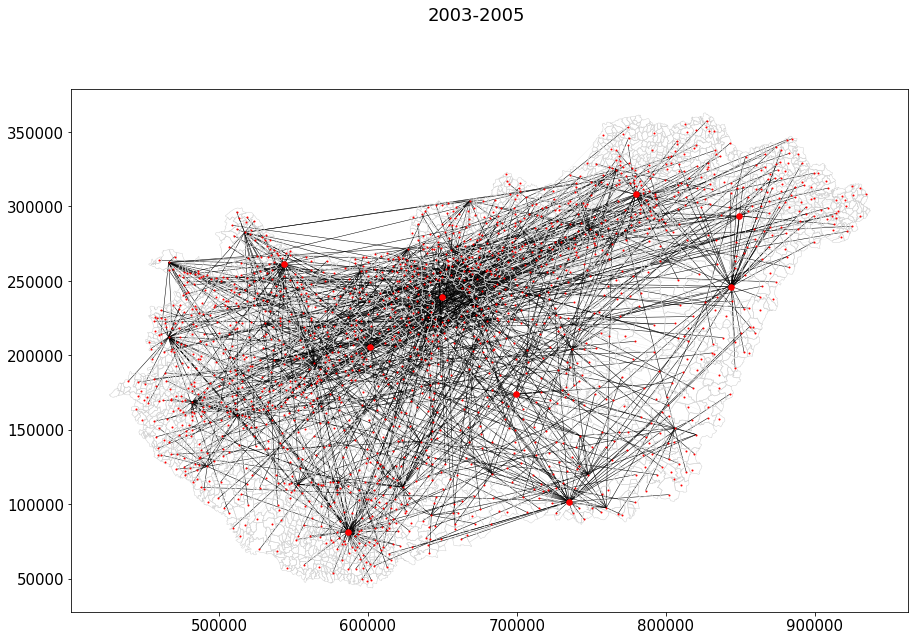

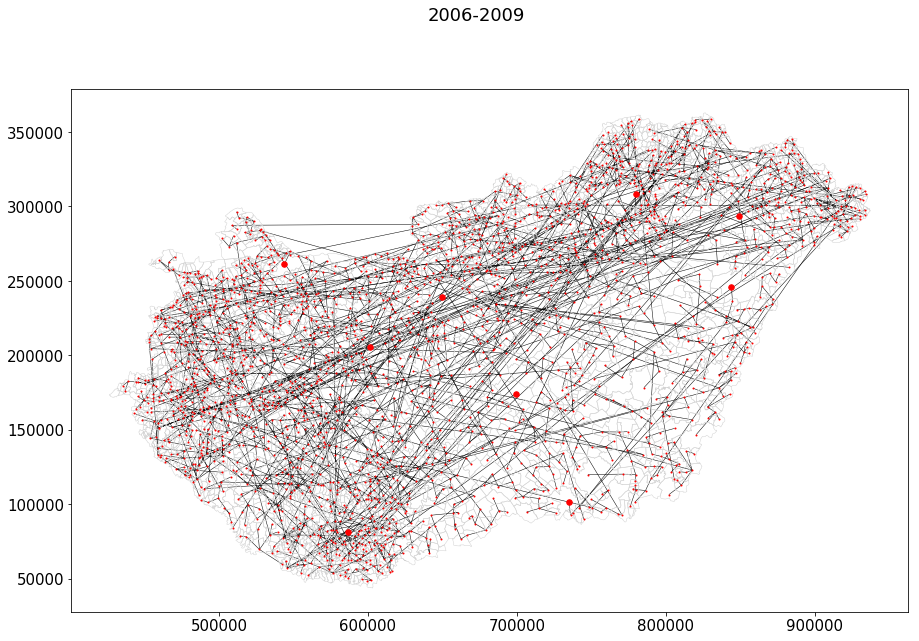

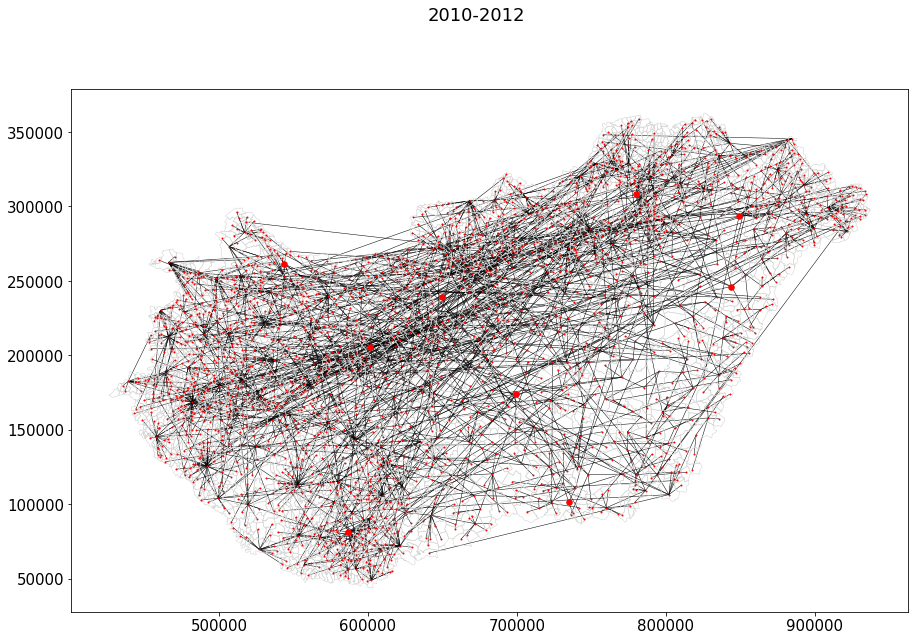

In [22]:
for k in range(1,4):
    # create minimum arborencence edgelists
    edmonds_elist,nodemap,nodemap_back = create_edgelist(k, additional_node=None,reach_bp=True)
    
    # getting minimum arborescence trees, mapping back to original node_ids
    tree = edmonds(edmonds_elist)
    tree_csv = pd.DataFrame(tree,columns=['s','t'])
    tree_csv['InvitorCityId'] = tree_csv['s'].map(nodemap_back)
    tree_csv['CityId'] = tree_csv['t'].map(nodemap_back)
    
    # plotting
    fig,ax = plt.subplots(1,1,figsize=(15,10))
    cities.boundary.plot(ax=ax,color='lightgrey',linewidth=0.5)
    T = nx.from_edgelist(tree_csv[['InvitorCityId','CityId']].values)
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[~(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=1,ax=ax)
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=30,ax=ax)
    nx.draw_networkx_edges(T,pos,nodelist=nlist['CityId'].tolist(),width=[0.025 if u==379 else 0.5 for u,v in T.edges()],ax=ax)

    fig.suptitle(limname.get(k))

### only in Budapest component, root arbitrary

Num times something was set to 0:  4494


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Num times something was set to 0:  126868


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Num times something was set to 0:  13787


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


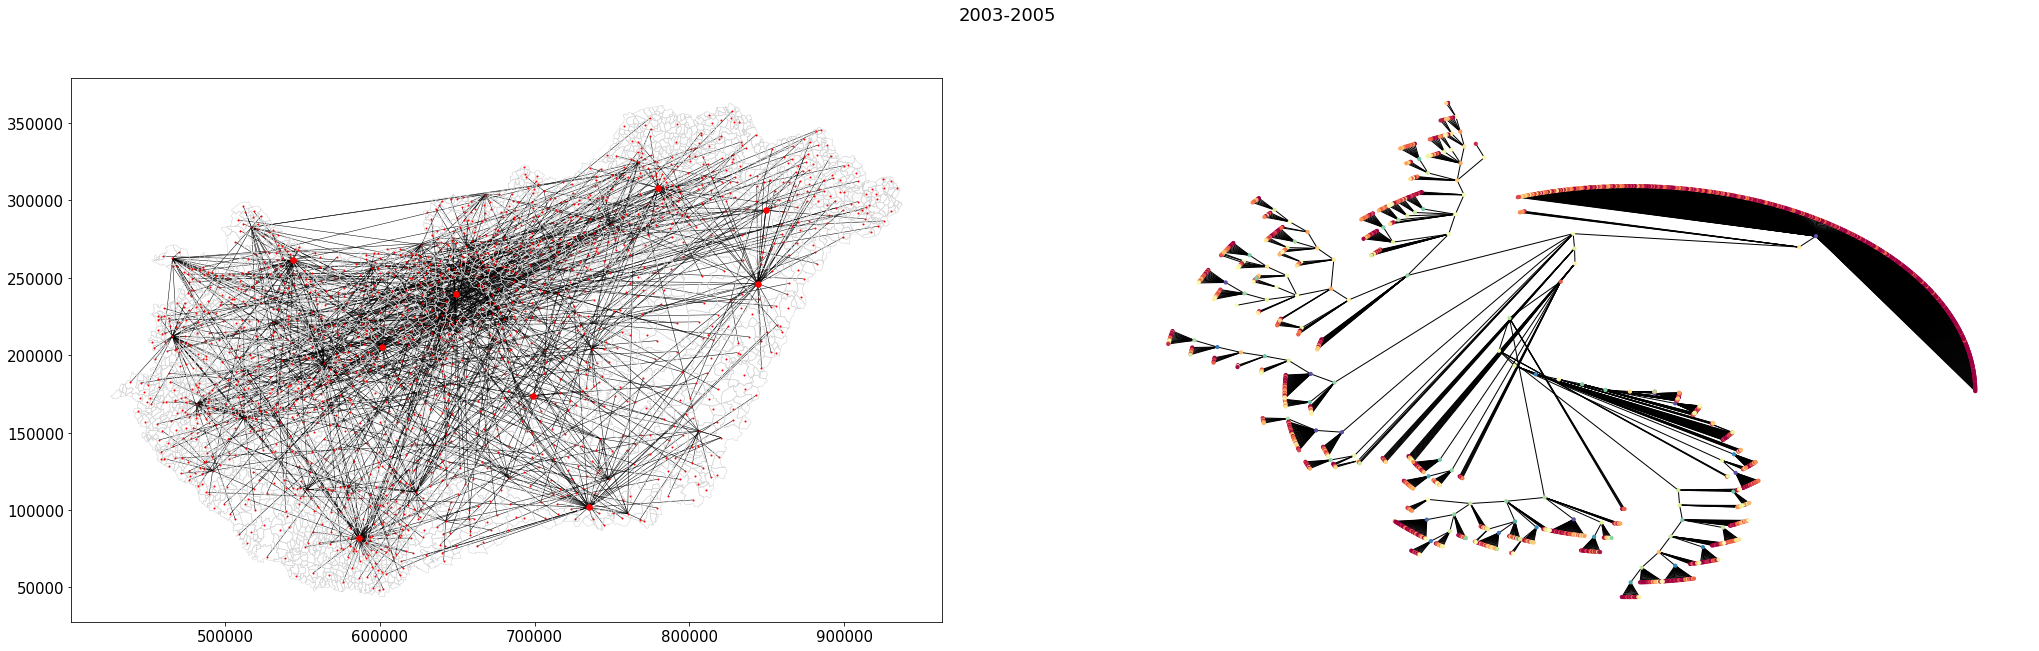

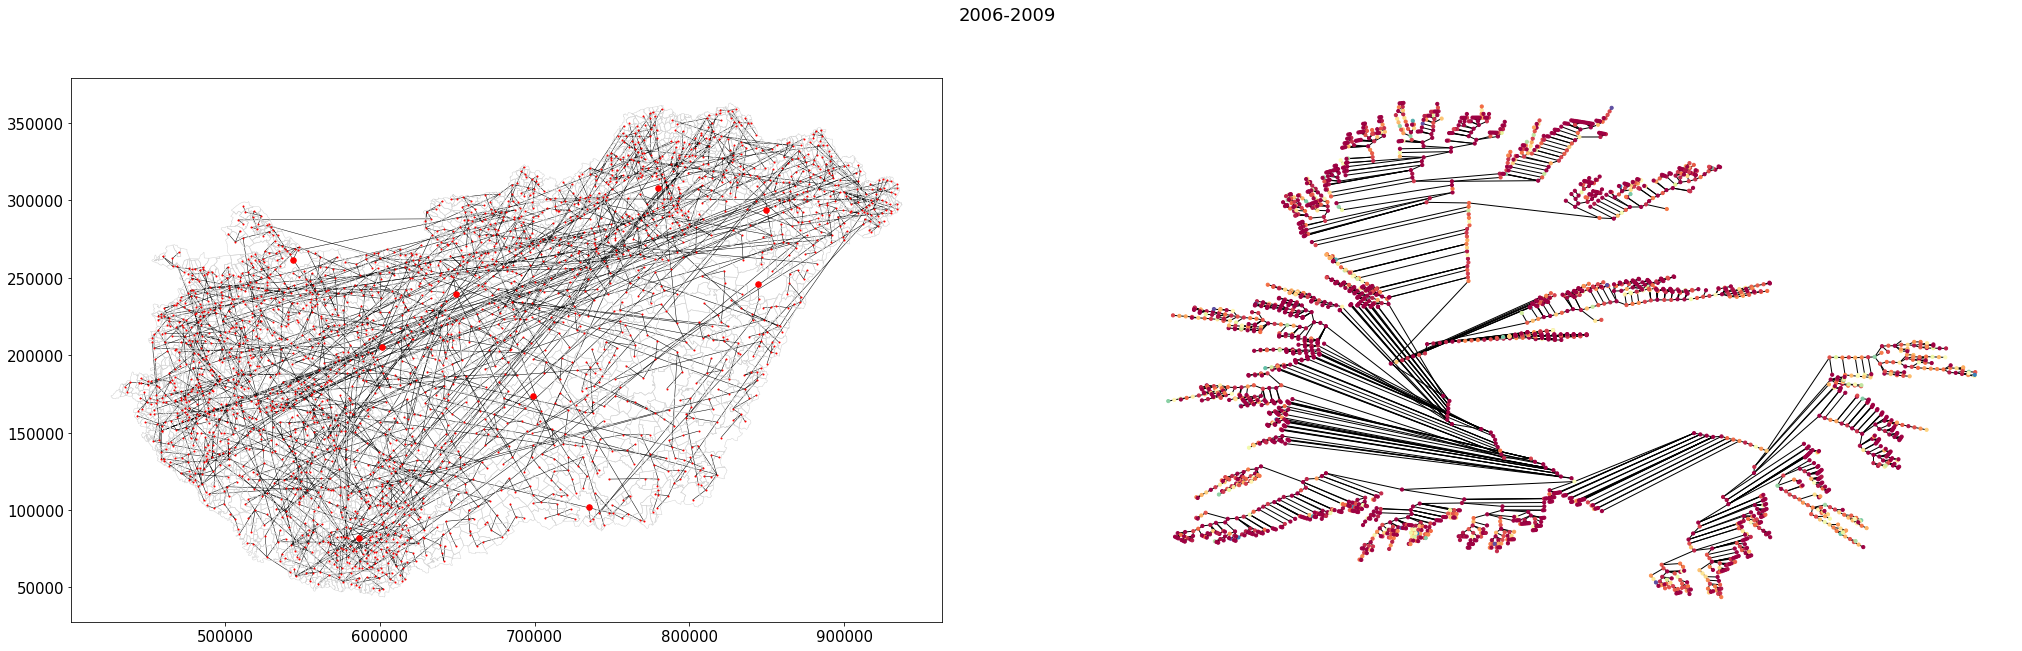

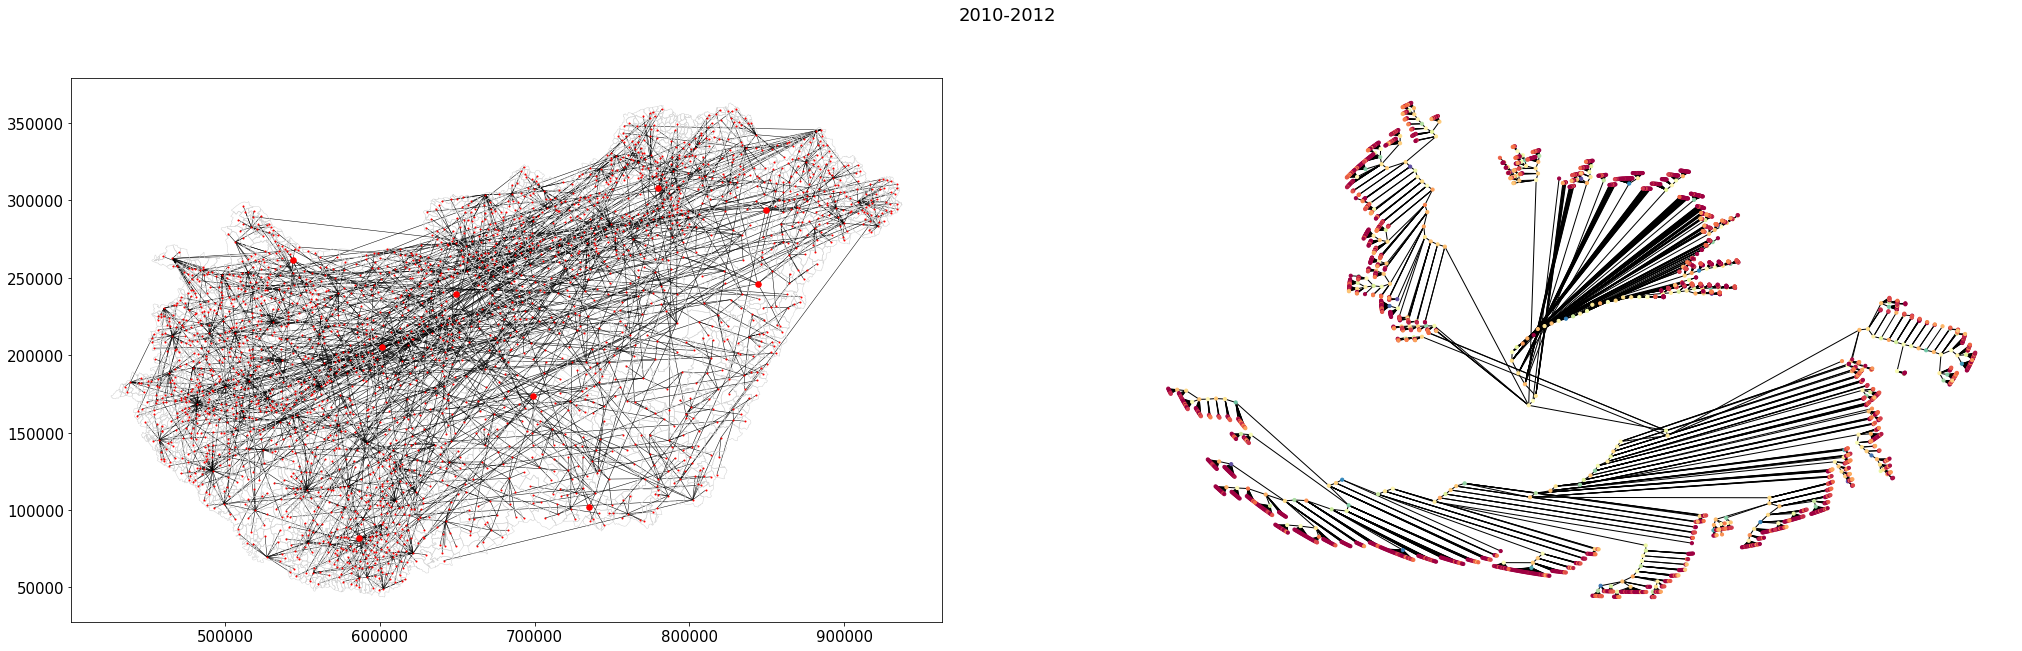

In [25]:
for k in range(1,4):
    edmonds_elist,nodemap,nodemap_back = create_edgelist(k, additional_node=10000,reach_bp=True)
    
    tree = edmonds(edmonds_elist)
    tree_csv = pd.DataFrame(tree,columns=['s','t'])
    tree_csv['InvitorCityId'] = tree_csv['s'].map(nodemap_back)
    tree_csv['CityId'] = tree_csv['t'].map(nodemap_back)
    
    # poltolas
    fig,ax = plt.subplots(1,2,figsize=(35,10))
    cities.boundary.plot(ax=ax[0],color='lightgrey',linewidth=0.5)
    T = nx.from_edgelist(tree_csv[['InvitorCityId','CityId']].values)

    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[~(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=1,ax=ax[0])
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=30,ax=ax[0])
    nx.draw_networkx_edges(T,pos,nodelist=nlist['CityId'].tolist(),width=[0.025 if u==379 else 0.5 for u,v in T.edges()],ax=ax[0])

    pos2 = graphviz_layout(T, prog="twopi")
    poplog = nlist.set_index('CityId')['PopLog'].to_dict()
    nx.draw_networkx_nodes(T,pos2,node_size=10,node_color=[poplog.get(n,1) for n in T.nodes()],cmap='Spectral',vmin=3,vmax=5,ax=ax[1])
    nx.draw_networkx_edges(T,pos2,ax=ax[1])
    tree_csv[['CityId','InvitorCityId']].to_csv('../iwiw_data/edmonds1_edges'+str(k)+'.csv',header=True,index=False)
    fig.suptitle(limname.get(k))
    plt.axis('off')
    ax[0].set_aspect('equal')

In [26]:
tree_pos = {}
tree_edgelist = {}

Num times something was set to 0:  4494


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Num times something was set to 0:  126868


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Num times something was set to 0:  13787


/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


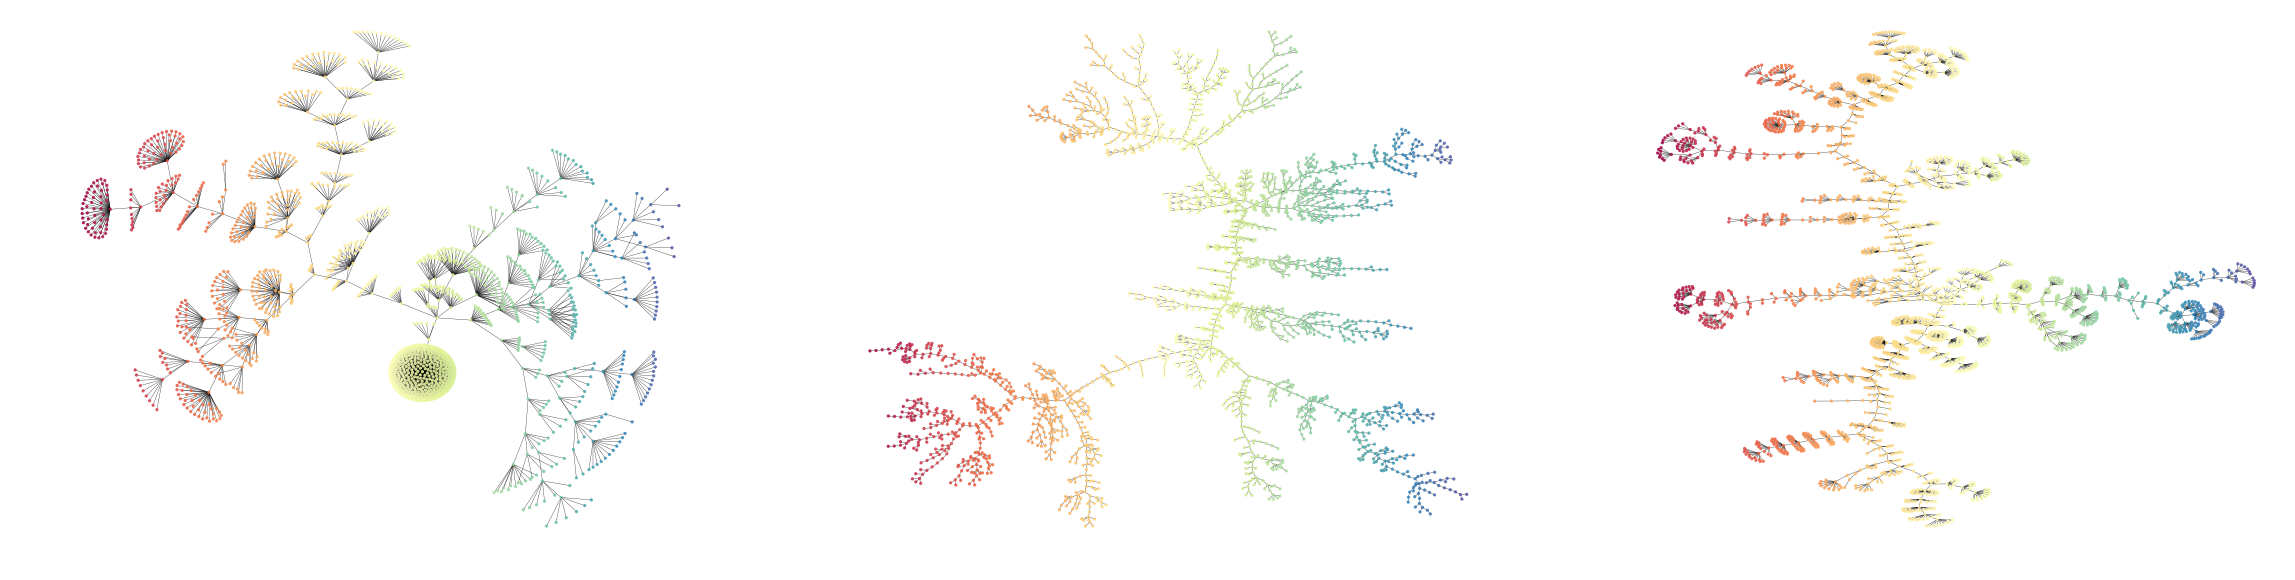

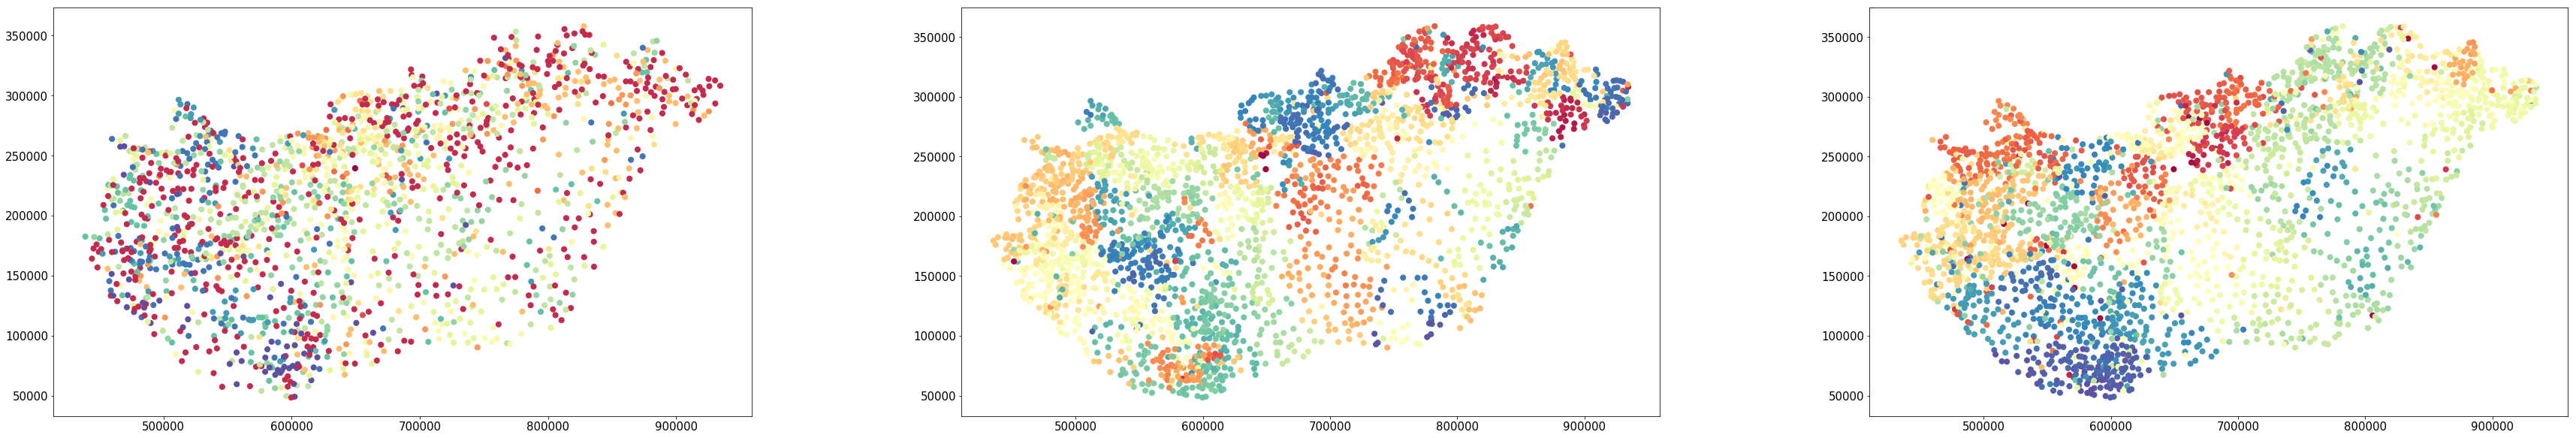

In [27]:
fig,ax = plt.subplots(1,3,figsize=(40,10))
fig2,ax2 = plt.subplots(1,3,figsize=(60,10))

for k in range(1,4):
    if k not in tree_edgelist:
        edmonds_elist,nodemap,nodemap_back = create_edgelist(k, additional_node=10000,reach_bp=False)

        tree = edmonds(edmonds_elist)
        tree_csv = pd.DataFrame(tree,columns=['s','t'])
        tree_csv['InvitorCityId'] = tree_csv['s'].map(nodemap_back)
        tree_csv['CityId'] = tree_csv['t'].map(nodemap_back)
        tree_edgelist[k] = tree_csv[['InvitorCityId','CityId']]

    T = nx.from_edgelist(tree_edgelist[k][['InvitorCityId','CityId']].values)
    
    l = nx.single_source_dijkstra_path_length(T,379)

    if k not in tree_pos:
        pos2 = graphviz_layout(T, prog="neato", root=379)
        tree_pos[k]=pos2
    pos2 = tree_pos[k]
    
    poplog = nlist.set_index('CityId')['PopLog'].to_dict()
    nx.draw_networkx_nodes(T,pos2,node_size=5,alpha=0.8,node_color=[pos2[ii][0] for ii in T.nodes()],cmap='Spectral',ax=ax[k-1])
    nx.draw_networkx_edges(T,pos2,ax=ax[k-1],width=0.3)
    
    n1 = list(set(nlist[~(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes())))
    n2 =  list(set(nlist[(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes())))
    nx.draw_networkx_nodes(T,pos,node_color = [l[ii] for ii in T.nodes()], cmap='Spectral', node_size=50,ax=ax2[k-1])
#     nx.draw_networkx_edges(T,pos,nodelist=nlist['CityId'].tolist(),width=[0.025 if u==379 else 0.5 for u,v in T.edges()],ax=ax2[k-1])
    
    

#     ax[k-1].set_title(limname.get(k))
    ax[k-1].axis('off')

plt.subplots_adjust(wspace=0.3)

# plt.savefig('../figs/trees3.pdf',bbox_inches='tight',density=600)

In [36]:
poplog_dict = nlist.set_index("CityId")['PopLog'].to_dict()
pos_dict = nlist.set_index("CityId")['geometry_eov'].to_dict()

In [38]:
for k in range(1,4):
    tree_edgelist[k]["source_poplog"] = tree_edgelist[k]["InvitorCityId"].map(poplog_dict)
    tree_edgelist[k]["target_poplog"] = tree_edgelist[k]["CityId"].map(poplog_dict)
    tree_edgelist[k]["source_pos"] = tree_edgelist[k]["InvitorCityId"].map(pos_dict)
    tree_edgelist[k]["target_pos"] = tree_edgelist[k]["CityId"].map(pos_dict)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [39]:
for k in range(1,4):
    tree_edgelist[k] = tree_edgelist[k][tree_edgelist[k]["InvitorCityId"]!=0]
    tree_edgelist[k]["popdiff"] = tree_edgelist[k]["source_poplog"] - tree_edgelist[k]["target_poplog"]
    tree_edgelist[k]["distance"] = tree_edgelist[k].apply(lambda row: row["source_pos"].distance(row["target_pos"]),axis=1)

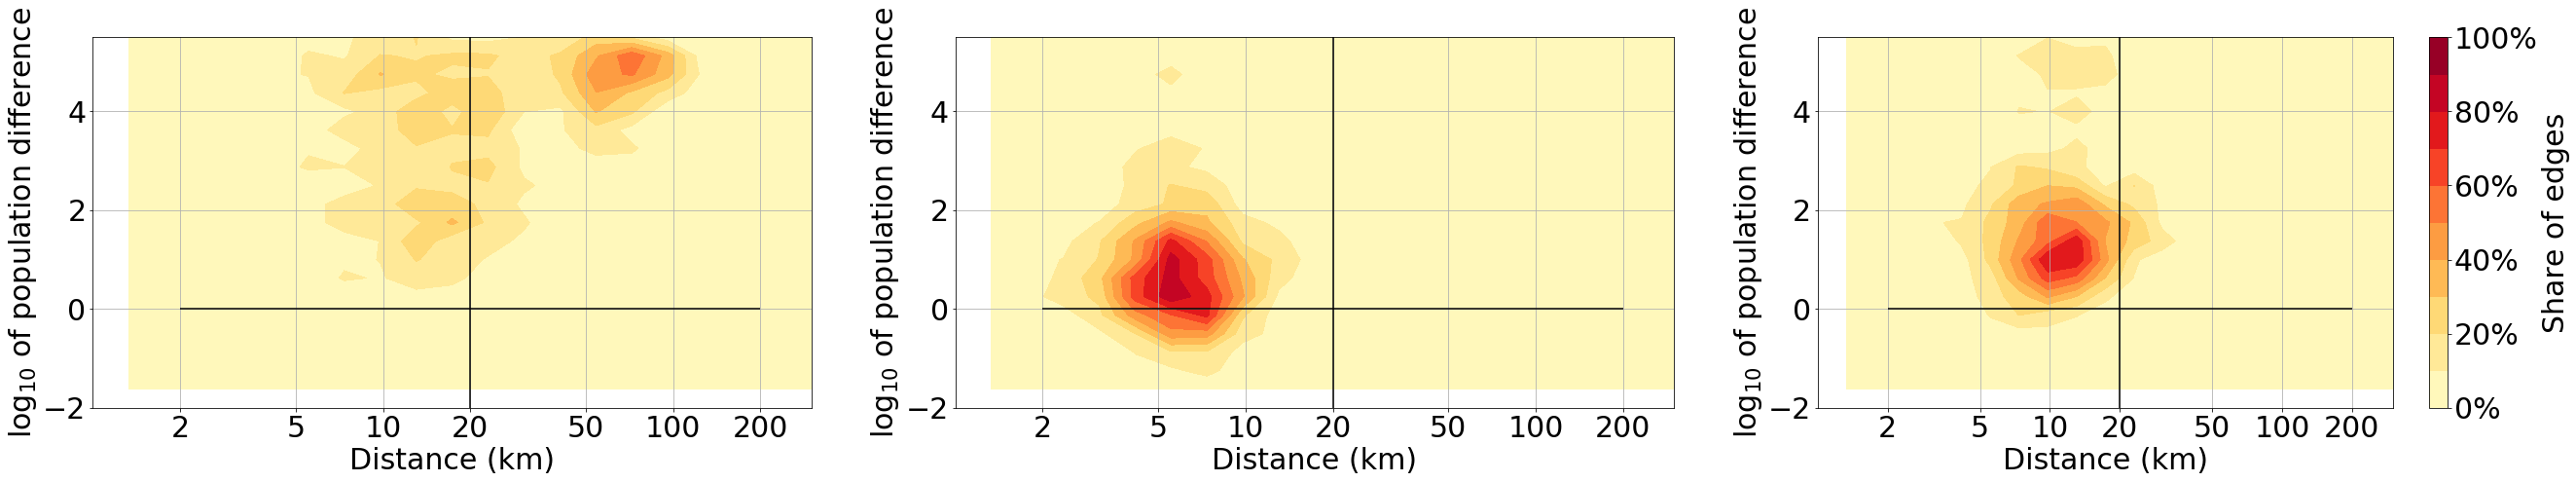

In [137]:
fig,axs = plt.subplots(1,3,figsize=(45,7))
for k in range(1,4):
    ax = axs[k-1]
    Z,xe,ye = np.histogram2d(np.log10(tree_edgelist[k]["distance"]/1000), tree_edgelist[k]["popdiff"],range=((0,np.log10(300)),(-2,5.5)),bins=20, normed=True)
                            
    X,Y = np.meshgrid(xe[1:],ye[1:])
    q = ax.contourf(X,Y,Z*100,cmap='YlOrRd',levels = np.linspace(0,100,11))
#     ax.plot(np.log10(tree_edgelist[k]["distance"]/1000), tree_edgelist[k]["popdiff"],'o',markersize=1)
#     ax.semilogx()
    ax.set_xlim(0,np.log10(300))
    ax.set_ylim(-2,5.5)
    ax.set_xticks(np.log10([2,5,10,20,50,100,200]))
    ax.set_xticklabels([2,5,10,20,50,100,200])
    ax.hlines([0],np.log10(2),np.log10(200))
    ax.vlines([np.log10(20)],-2,5.5)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel(r'$\log_{10}$ of population difference')
    ax.grid()
plt.colorbar(q, format="%.0f%%",label="Share of edges")
fig.savefig('../figs/tree_edges3.pdf',bbox_inches='tight',density=600)